# TF-IDF

## 方法定义

In [1]:
import numpy as np
import os
import nltk
import torch
import torch.nn
import torchtext.vocab as vocab
from sklearn import metrics
import pandas as pd
import warnings
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_curve, auc
from sklearn.linear_model import LinearRegression
from datetime import datetime
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")


In [2]:

def load_data():
    df = pd.read_csv("../data_cleaning/product_classification.csv", encoding='utf_8_sig')
    print(df.columns)
    texts = df['name'].values
    df = df.fillna(-1)
    # labels = np.argmax(df[df.columns[-4:]].values, axis=1)
    labels = df['cat'].values
    label2id = {l: i for i, l in enumerate(set(labels))}
    id2label = {i: l for l, i in label2id.items()}
    labels = [label2id[l] for l in labels]
    return texts, labels, id2label

In [3]:
def text_preprocess(text):
    text = str(text)
    english_punctuations = [',', '.', ':', ';', '?', '(', ')', '[', ']', '&', '!', '*', '@', '#', '$', '%', '\'', '/']
    text = "".join([(a if a not in english_punctuations else " ") for a in text])
    text = " ".join(nltk.tokenize.word_tokenize(text.lower()))
    return text

In [4]:
def evaluation(predictions, labels, id2label, model_name=None):
    acc = accuracy_score(labels, predictions)
    recall = recall_score(labels, predictions, average="macro")
    f1 = f1_score(labels, predictions, average="macro")
    report = metrics.classification_report(labels, predictions,
                                           target_names=[id2label[i] for i in range(len(id2label))])
    info = "acc:%s, recall:%s, f1 score:%s" % (acc, recall, f1)
    if model_name is not None:
        info = "%s: %s" % (model_name, info)
    print(info)
    print(report)


## 数据处理

In [5]:
texts, labels, id2label = load_data()  
texts = [text_preprocess(t) for t in texts]

Index(['name', 'cat'], dtype='object')


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer 
vectorizer = TfidfVectorizer() 
features=vectorizer.fit_transform(texts)
print("data len:", len(texts))
print("id2label",id2label)

data len: 35789
id2label {0: 'Pantry', 1: 'Beer, Cider & Wine', 2: 'Pets', 3: 'Chilled, Frozen & Desserts', 4: 'Kitchen, Dining & Household', 5: 'Drinks', 6: 'Baby, Toddler & Kids', 7: 'Personal Care', 8: 'Fresh Foods & Bakery'}


In [7]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.25,
                                                                            random_state=3)



## 预跑模型和优化

### LR

In [8]:
# logistic
model = LogisticRegression()
model.fit(x_train, y_train)
predict_labels = model.predict(x_test)
# print(predict_labels)
predict_labels = [np.round(p) for p in predict_labels]
max_label = len(id2label) - 1
predict_labels = [l if max_label >= l else max_label for l in predict_labels]
min_label = 0
predict_labels = [l if min_label <= l else min_label for l in predict_labels]
evaluation(predict_labels, y_test,id2label, "logistic")

logistic: acc:0.9367456414841305, recall:0.9212843924883755, f1 score:0.9375483786733333
                             precision    recall  f1-score   support

                     Pantry       0.89      0.97      0.93      2607
         Beer, Cider & Wine       0.99      0.97      0.98       894
                       Pets       1.00      0.94      0.97       286
 Chilled, Frozen & Desserts       0.92      0.84      0.88       817
Kitchen, Dining & Household       0.96      0.97      0.97      1240
                     Drinks       0.96      0.93      0.95       500
       Baby, Toddler & Kids       0.98      0.84      0.90       221
              Personal Care       0.96      0.94      0.95      1070
       Fresh Foods & Bakery       0.93      0.89      0.91      1313

                   accuracy                           0.94      8948
                  macro avg       0.96      0.92      0.94      8948
               weighted avg       0.94      0.94      0.94      8948



### KNN

In [25]:
# knn
k = len(id2label)
model = KNeighborsClassifier(n_neighbors=k)
model.fit(x_train, y_train)
knn_predict_labels = model.predict(x_test)
evaluation(knn_predict_labels, y_test, id2label, "knn")

knn: acc:0.9314930710773357, recall:0.9246811074633824, f1 score:0.9341886100708082
                             precision    recall  f1-score   support

       Fresh Foods & Bakery       0.87      0.92      0.89      1313
                     Pantry       0.92      0.94      0.93      2607
 Chilled, Frozen & Desserts       0.91      0.84      0.87       817
       Baby, Toddler & Kids       0.98      0.89      0.94       221
         Beer, Cider & Wine       0.98      0.97      0.97       894
Kitchen, Dining & Household       0.96      0.95      0.95      1240
                       Pets       0.97      0.93      0.95       286
                     Drinks       0.95      0.95      0.95       500
              Personal Care       0.96      0.94      0.95      1070

                   accuracy                           0.93      8948
                  macro avg       0.94      0.92      0.93      8948
               weighted avg       0.93      0.93      0.93      8948



KNN-寻找最佳K值

The optimal number of neighbors is 1


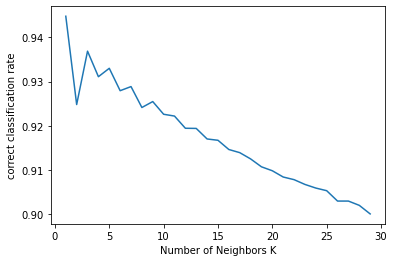

In [24]:
from sklearn.model_selection import cross_val_score
def knn_cross_validation(x_train, y_train):
    k_list = list(range(1, 30))
    list_scores = []

    for k in k_list:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, x_train, y_train, cv=10, scoring='accuracy')
        list_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in list_scores]
    optimal_k = k_list[MSE.index(min(MSE))]
    print ("The optimal number of neighbors is %d" % optimal_k)
    # plot misclassification error vs k
    # plt.plot(k_lst, MSE)
    # plt.ylabel('Misclassification Error')
    plt.plot(k_list, list_scores)
    plt.xlabel('Number of Neighbors K')
    plt.ylabel('correct classification rate')
    plt.show()
    return optimal_k

k = knn_cross_validation(x_train, y_train)

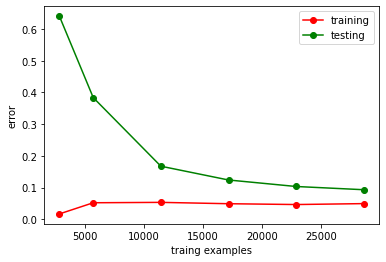

In [31]:
knn = KNeighborsClassifier(n_neighbors=9)
train_sizes,train_score,test_score = learning_curve(knn,features, labels,cv=5, scoring='accuracy', train_sizes=[0.1, 0.25, 0.5, 0.75, 1])

train_sizes,train_score,test_score = learning_curve(knn,features,labels,train_sizes=[0.1,0.2,0.4,0.6,0.8,1],cv=5,scoring='accuracy')
train_error =  1- np.mean(train_score,axis=1)
test_error = 1- np.mean(test_score,axis=1)
plt.plot(train_sizes,train_error,'o-',color = 'r',label = 'training')
plt.plot(train_sizes,test_error,'o-',color = 'g',label = 'testing')
plt.legend(loc='best')
plt.xlabel('traing examples')
plt.ylabel('error')
plt.show()

### SVM

In [29]:
# undersampled
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
model = OneVsRestClassifier(SVC())
model.fit(x_train, y_train) 
svm_predict_labels = model.predict(x_test)
evaluation(svm_predict_labels, y_test, id2label, "svm")

svm: acc:0.9618909253464462, recall:0.9576032825547274, f1 score:0.9639073244668006
                             precision    recall  f1-score   support

       Fresh Foods & Bakery       0.95      0.94      0.94      1313
                     Pantry       0.94      0.98      0.96      2607
 Chilled, Frozen & Desserts       0.95      0.90      0.92       817
       Baby, Toddler & Kids       0.98      0.92      0.95       221
         Beer, Cider & Wine       0.99      0.99      0.99       894
Kitchen, Dining & Household       0.98      0.98      0.98      1240
                       Pets       1.00      0.98      0.99       286
                     Drinks       0.97      0.98      0.98       500
              Personal Care       0.98      0.96      0.97      1070

                   accuracy                           0.96      8948
                  macro avg       0.97      0.96      0.96      8948
               weighted avg       0.96      0.96      0.96      8948



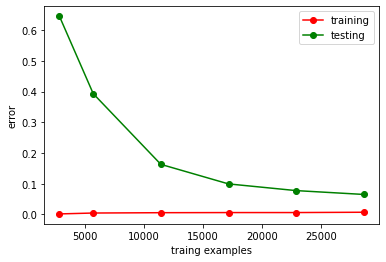

In [30]:
train_sizes,train_score,test_score = learning_curve(SVC(),features,labels,train_sizes=[0.1,0.2,0.4,0.6,0.8,1],cv=5,scoring='accuracy')
train_error =  1- np.mean(train_score,axis=1)
test_error = 1- np.mean(test_score,axis=1)
plt.plot(train_sizes,train_error,'o-',color = 'r',label = 'training')
plt.plot(train_sizes,test_error,'o-',color = 'g',label = 'testing')
plt.legend(loc='best')
plt.xlabel('traing examples')
plt.ylabel('error')
plt.show()

SVM-gridSearch寻找最优参数

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(x_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(x_test)
    print(classification_report(y_true, y_pred))
    print()


# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.031 (+/-0.000) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.031 (+/-0.000) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.826 (+/-0.090) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.031 (+/-0.000) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.935 (+/-0.004) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.826 (+/-0.090) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.964 (+/-0.005) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.935 (+/-0.004) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.960 (+/-0.004) for {'C': 1, 'kernel': 'linear'}
0.959 (+/-0.008) for {'C': 10, 'kernel': 'linear'}
0.949 (+/-0.008) for {'C': 100, 'kernel': 'linear'}
0.945 (+/-0.005) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed

NameError: name 'X_test' is not defined

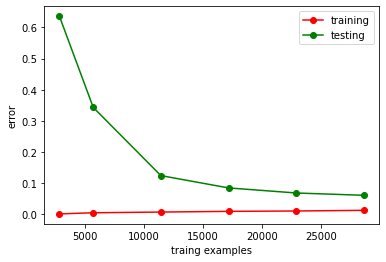

In [46]:
train_sizes,train_score,test_score = learning_curve(SVC(C=1000, gamma=0.001, kernel='rbf'),features,labels,train_sizes=[0.1,0.2,0.4,0.6,0.8,1],cv=5,scoring='accuracy')
train_error =  1- np.mean(train_score,axis=1)
test_error = 1- np.mean(test_score,axis=1)
plt.plot(train_sizes,train_error,'o-',color = 'r',label = 'training')
plt.plot(train_sizes,test_error,'o-',color = 'g',label = 'testing')
plt.legend(loc='best')
plt.xlabel('traing examples')
plt.ylabel('error')
plt.show()


In [48]:
# undersampled
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
model = OneVsRestClassifier(SVC(C=1000, gamma=0.001, kernel='rbf'))
model.fit(x_train, y_train) 
svm_predict_labels = model.predict(x_test)
evaluation(svm_predict_labels, y_test, id2label, "svm")

svm: acc:0.9583147071971391, recall:0.9568525001279191, f1 score:0.9613551029761737
                             precision    recall  f1-score   support

       Fresh Foods & Bakery       0.94      0.93      0.93      1313
                     Pantry       0.94      0.96      0.95      2607
 Chilled, Frozen & Desserts       0.92      0.90      0.91       817
       Baby, Toddler & Kids       0.98      0.93      0.96       221
         Beer, Cider & Wine       0.99      0.99      0.99       894
Kitchen, Dining & Household       0.98      0.98      0.98      1240
                       Pets       1.00      0.98      0.99       286
                     Drinks       0.97      0.97      0.97       500
              Personal Care       0.98      0.96      0.97      1070

                   accuracy                           0.96      8948
                  macro avg       0.97      0.96      0.96      8948
               weighted avg       0.96      0.96      0.96      8948



### LightGBM with GBDT

In [26]:
import lightgbm as lgb

def lgb_model(x_train, x_test, y_train, y_test, verbose):
    params = {'num_leaves': 60,
    'min_data_in_leaf': 30,
    'objective': 'multiclass',
    'num_class': 33,
    'max_depth': 7,
    'learning_rate': 0.03,
    "min_sum_hessian_in_leaf": 6,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.8,
    "bagging_seed": 11,
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 15,
    'metric': 'multi_error',
    "random_state": 2020
          }

    evals_result = {}
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_test = lgb.Dataset(x_test, y_test, reference=lgb_train)
    model = lgb.train(params
                      , lgb_train
                      , num_boost_round = 100000
                      , valid_sets = [lgb_train, lgb_test]
                      , verbose_eval = verbose
                      , early_stopping_rounds = 500
                      , evals_result=evals_result
                     )

    print('Predicting...') 
    y_prob = model.predict(x_test, num_iteration=model.best_iteration)
    lgb_predict_labels = [list(x).index(max(x)) for x in y_prob]
    print("AUC score: {:<8.5f}".format(metrics.accuracy_score(lgb_predict_labels, y_test)))
    report = metrics.classification_report(y_test, lgb_predict_labels, target_names=[id2label[i] for i in range(len(id2label))])
    print(report)
    return model, evals_result

In [27]:

model, evals_result = lgb_model(x_train, x_test, y_train, y_test, verbose=False)

Predicting...
AUC score: 0.86109 
                             precision    recall  f1-score   support

       Fresh Foods & Bakery       0.87      0.80      0.84      1313
                     Pantry       0.80      0.92      0.85      2607
 Chilled, Frozen & Desserts       0.77      0.73      0.75       817
       Baby, Toddler & Kids       0.95      0.82      0.88       221
         Beer, Cider & Wine       0.97      0.92      0.94       894
Kitchen, Dining & Household       0.89      0.84      0.87      1240
                       Pets       0.98      0.91      0.94       286
                     Drinks       0.94      0.89      0.91       500
              Personal Care       0.91      0.85      0.88      1070

                   accuracy                           0.86      8948
                  macro avg       0.90      0.85      0.87      8948
               weighted avg       0.87      0.86      0.86      8948



<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='multi_error'>

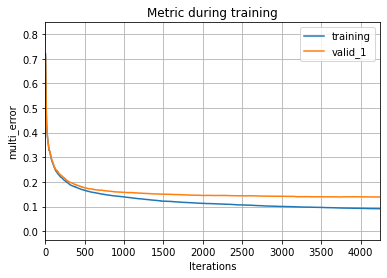

In [28]:
lgb.plot_metric(evals_result)